In [1]:
import copy
import pathlib
import os.path
import json
import hashlib
import itertools
import collections
from typing import Any, Sequence, Mapping, Set

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

2024-06-11 19:49:41.345728: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 19:49:41.433607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 19:49:41.435037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 19:49:43.368513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from rlplg import envsuite, core
from daaf import estimator_metrics

In [5]:
ENVS_MAPPING = {
    (
        "IceWorld",
        "4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64JMEBETNDXFFPYWTQJF46S5BJ4NXXCHNMJSLII3ROYXI76DFOC3VAABGNVA=",
    ): {"args": '{"map_name": "4x4"}', "name": "4x4"},
    ("ABCSeq", "10"): {
        "args": '{"length": 10, "distance_penalty": false}',
        "name": "n=10",
    },
    (
        "RedGreenSeq",
        "NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJEZOYLTSLB4ID4WHQG57XQPNUHGZCFDCWHYGXWSBW7FBWYRZGAGBW4J7MEQ=",
    ): {
        "args": '{"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}',
        "name": "n=9",
    },
    (
        "FrozenLake-v1",
        "U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK6NGTAAU62O2DKMOEGACNNUQOSWGYYOV7LQHK7GAWG2CL3U3RZJFIEIB5I=",
    ): {"args": '{"is_slippery": false, "map_name": "4x4"}', "name": "4x4"},
    ("TowerOfHanoi", "4"): {"args": '{"num_disks": 4}', "name": "disks=4"},
    ("ABCSeq", "7"): {
        "args": '{"length": 7, "distance_penalty": false}',
        "name": "n=7",
    },
    (
        "IceWorld",
        "JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUAK5VNQ4KE45QZINGYFU5GR6D7F3GJMW7EC4TAY5PHCYRN5GPGP7YNACHEI=",
    ): {"args": '{"map_name": "8x8"}', "name": "8x8"},
    (
        "GridWorld",
        "P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3GQZSLKURMS2SRPEUF6O65F3ETJXEFNTR3UYS73TUCIIU3YIONXHAR6WE5A=",
    ): {
        "args": '{"grid": "oooooooooooo\\noooooooooooo\\noooooooooooo\\nsxxxxxxxxxxg"}',
        "name": "4x12",
    },
}

In [6]:
EXCLUDED_ENVS = set(["FrozenLake-v1"])

## Load Data

In [7]:
def read_data(paths: Sequence[str]) -> pd.DataFrame:
    dfs = []
    for path in paths:
        dfs.append(
            pd.read_json(path, lines=True)
        )
    return pd.concat(dfs)

In [8]:
def get_env_level(env_spec):
    loaded_env_spec = envsuite.load(env_spec["name"], **env_spec["args"])
    return loaded_env_spec.level

In [9]:
df_raw = read_data(
        tf.io.gfile.glob(os.path.join(str(pathlib.Path.home()), "fs/daaf/exp/reward-estjob/logs/1717715230/*.json"))
    )

In [10]:
df_raw

,result,uid,env_spec,run_id,reward_period,accuracy,max_episodes,log_episode_frequency,method
0,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",1eb6dbb3-cf1d-46d1-bcd1-4bcd4439e8d6,"{""name"": ""IceWorld"", ""args"": {""map_name"": ""4x4""}}",15,5,1.000000e-08,10000,100,factor-ts
1,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",b32ca8d7-fa45-42b2-8251-cc5c7c3747c9,"{""name"": ""GridWorld"", ""args"": {""grid"": ""oooooo...",4,3,1.000000e-08,10000,100,prefill-buffer
2,"{'least': None, 'ols_em': None, 'episodes': 10...",884ce390-e03a-483a-81b0-93f37669097f,"{""name"": ""IceWorld"", ""args"": {""map_name"": ""8x8""}}",16,8,1.000000e-08,10000,100,plain
3,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",caba6213-69d6-4639-ac4d-d8f74dc2e10e,"{""name"": ""IceWorld"", ""args"": {""map_name"": ""4x4""}}",15,7,1.000000e-08,10000,100,factor-ts
4,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",2f86d7bf-a0e4-4727-98a1-5f6a28428aa2,"{""name"": ""IceWorld"", ""args"": {""map_name"": ""4x4""}}",13,6,1.000000e-08,10000,100,plain
...,...,...,...,...,...,...,...,...,...
8,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",10fc62bc-443e-4b5a-879f-f326141b97a0,"{""name"": ""GridWorld"", ""args"": {""grid"": ""oooooo...",19,4,1.000000e-08,10000,100,factor-ts
9,"{'least': [3.867325934e-21, -2.47337715e-20, 1...",f1263d16-cf56-4a72-9caf-c2a03ee59a37,"{""name"": ""FrozenLake-v1"", ""args"": {""is_slipper...",1,3,1.000000e-08,10000,100,factor-ts
10,"{'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...",cbf5f4cd-f84c-4bd0-8827-d010c0ed0dea,"{""name"": ""ABCSeq"", ""args"": {""length"": 7, ""dist...",10,2,1.000000e-08,10000,100,plain
11,"{'least': None, 'ols_em': None, 'episodes': 10...",29d4cace-7025-4541-9131-8020de4173d9,"{""name"": ""IceWorld"", ""args"": {""map_name"": ""8x8""}}",9,4,1.000000e-08,10000,100,plain


In [11]:
df_raw.iloc[0]

result                   {'least': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0,...
uid                                   1eb6dbb3-cf1d-46d1-bcd1-4bcd4439e8d6
env_spec                 {"name": "IceWorld", "args": {"map_name": "4x4"}}
run_id                                                                  15
reward_period                                                            5
accuracy                                                               0.0
max_episodes                                                         10000
log_episode_frequency                                                  100
method                                                           factor-ts
Name: 0, dtype: object

In [12]:
def proc_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for row in df_raw.to_dict("records"):
        if row["method"] in set(["factor-ts"]):
            continue
        new_row = copy.deepcopy(row)
        # parse env spec
        new_row["env_spec"] = json.loads(new_row["env_spec"])
        # unpack result
        result = new_row["result"]
        del new_row["result"]
        for key, value in result.items():
            new_row[key] = value
        # add env id;
        new_row["env_name"] = new_row["env_spec"]["name"]
        new_row["env_level"] = get_env_level(new_row["env_spec"])
        eid = (new_row["env_spec"]["name"], new_row["env_level"])
        new_row["env_label"] = ENVS_MAPPING[eid]["name"]
        rows.append(new_row)
    return pd.DataFrame(rows)

In [13]:
df_results = proc_data(df_raw)

In [14]:
df_results

,uid,env_spec,run_id,reward_period,accuracy,max_episodes,log_episode_frequency,method,least,ols_em,episodes,steps,full_rank,samples,buffer_size,episode_visited_states_count,meta,env_name,env_level,env_label
0,b32ca8d7-fa45-42b2-8251-cc5c7c3747c9,"{'name': 'GridWorld', 'args': {'grid': 'oooooo...",4,3,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -0.9999999999, ...",22,119995,True,1693,155648,"{'34': 2, '38': 12, '36': 4, '37': 2, '30': 1,...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12
1,884ce390-e03a-483a-81b0-93f37669097f,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",16,8,1.000000e-08,10000,100,plain,None,None,10000,329975,False,19339,262144,"{'18': 258, '10': 1051, '23': 88, '12': 929, '...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
2,2f86d7bf-a0e4-4727-98a1-5f6a28428aa2,"{'name': 'IceWorld', 'args': {'map_name': '4x4'}}",13,6,1.000000e-08,10000,100,plain,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -32...","[-1.0000004423, -1.0000022971, -0.999999528400...",4330,37431,True,1471,65536,"{'6': 419, '8': 81, '3': 1729, '4': 1009, '5':...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4
3,ce93319e-9dbc-4f1b-b50f-f3968a2ad151,"{'name': 'ABCSeq', 'args': {'length': 10, 'dis...",16,7,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0000000001, -1.0, -1.0, -1.0, -1.0, -1.0, ...",240,23589,True,2946,112640,{'11': 240},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",ABCSeq,10,n=10
4,dab32a7a-df2e-44c3-a452-c0514eda0c42,"{'name': 'TowerOfHanoi', 'args': {'num_disks':...",6,3,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",203,315773,True,3337,497664,"{'75': 5, '50': 4, '32': 1, '81': 22, '80': 18...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",TowerOfHanoi,4,disks=4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0b3c4513-336b-4f6d-9d9a-063648b152d8,"{'name': 'RedGreenSeq', 'args': {'cure': ['red...",9,6,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.000000551, -0.999999767, -0.9999999787, -0...",12,317,True,49,27648,{'9': 12},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9
2236,b930dc60-061c-4ba5-b247-fe9560b25705,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",19,5,1.000000e-08,10000,100,plain,None,None,10000,328087,False,11032,262144,"{'18': 265, '13': 829, '8': 928, '21': 163, '9...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
2237,cbf5f4cd-f84c-4bd0-8827-d010c0ed0dea,"{'name': 'ABCSeq', 'args': {'length': 7, 'dist...",10,2,1.000000e-08,10000,100,plain,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",56,2598,True,233,57344,{'8': 56},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",ABCSeq,7,n=7
2238,29d4cace-7025-4541-9131-8020de4173d9,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",9,4,1.000000e-08,10000,100,plain,None,None,10000,333099,False,5260,262144,"{'12': 893, '17': 357, '18': 269, '14': 652, '...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8


In [15]:
df_results.iloc[0]

uid                                          b32ca8d7-fa45-42b2-8251-cc5c7c3747c9
env_spec                        {'name': 'GridWorld', 'args': {'grid': 'oooooo...
run_id                                                                          4
reward_period                                                                   3
accuracy                                                                      0.0
max_episodes                                                                10000
log_episode_frequency                                                         100
method                                                             prefill-buffer
least                           [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
ols_em                          [-1.0, -1.0, -1.0, -1.0, -1.0, -0.9999999999, ...
episodes                                                                       22
steps                                                                      119995
full_rank       

## True Reward Fn

In [16]:
def get_dynamics(environment):
    try:
        return getattr(environment, "transition")
    except AttributeError:
        return getattr(environment, "P")

In [17]:
def extract_env_info(spec):
    env_spec = envsuite.load(name=spec["name"], **spec["args"])
    dynamics = env_spec.mdp.transition
    num_states = env_spec.mdp.env_desc.num_states
    num_actions = env_spec.mdp.env_desc.num_actions
    reward_m = np.ndarray(shape=(num_states, num_actions), dtype=np.float64)
    for state in range(num_states):
        for action in range(num_actions):
            # average over next possible states
            reward = 0.0
            for prob, next_state, actual_reward, terminated in dynamics[state][action]:
                reward += prob * actual_reward
            reward_m[state, action] = reward
    terminal_states = core.infer_env_terminal_states(env_spec.mdp.transition)
    return {"reward_m": reward_m, "desc":  env_spec.mdp.env_desc, "terminal_states": terminal_states}

In [18]:
extract_env_info(spec={"name": "IceWorld", "args": {"map_name": "4x4"}})

{'reward_m': array([[ -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1., -32.],
        [ -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1., -32.],
        [ -1., -32.,  -1.,  -1.],
        [  0.,   0.,   0.,   0.],
        [-32., -32.,  -1.,  -1.],
        [  0.,   0.,   0.,   0.],
        [ -1.,  -1.,  -1., -32.],
        [ -1.,  -1., -32.,  -1.],
        [ -1., -32.,  -1.,  -1.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [-32.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.],
        [  0.,   0.,   0.,   0.]]),
 'desc': EnvDesc(num_states=16, num_actions=4),
 'terminal_states': {5, 7, 11, 12, 15}}

In [19]:
def get_env_info(df_results: pd.DataFrame) -> Mapping[str, np.ndarray]:
    reward_info = {}
    for row, rid in zip(df_results.to_dict("records"), itertools.count()):
        eid = (row["env_name"], row["env_level"])
        if eid not in reward_info:
            reward_info[eid] = extract_env_info(row["env_spec"])
    return reward_info

In [20]:
env_info = get_env_info(df_results)

In [21]:
len(env_info)

8

## Reached Full Rank

First question we ask is - in how many runs did we reach full rank to estimate the reward function?

In [22]:
def calc_completion(df_results: pd.DataFrame) -> pd.DataFrame:
    df_raw = copy.deepcopy(df_results[["env_name", "env_level", "env_label", "reward_period", "method", "full_rank"]])
    df_completion = df_raw.groupby(
        ["env_name", "env_level", "env_label", "reward_period", "method"]
    ).agg({"full_rank": ["sum", "count"]}).reset_index()

    return pd.DataFrame({
        "env_name": df_completion["env_name"],
        "env_level": df_completion["env_level"],
        "env_label": df_completion["env_label"],
        "reward_period": df_completion["reward_period"],
        "method": df_completion["method"],
        "total": df_completion["full_rank"]["count"],
        "completed": df_completion["full_rank"]["sum"],        
    })


In [23]:
df_completion = calc_completion(df_results)

In [24]:
df_completion

,env_name,env_level,env_label,reward_period,method,total,completed
0,ABCSeq,10,n=10,2,plain,20,20
1,ABCSeq,10,n=10,2,prefill-buffer,20,20
2,ABCSeq,10,n=10,3,plain,20,20
3,ABCSeq,10,n=10,3,prefill-buffer,20,20
4,ABCSeq,10,n=10,4,plain,20,20
...,...,...,...,...,...,...,...
107,TowerOfHanoi,4,disks=4,6,prefill-buffer,20,16
108,TowerOfHanoi,4,disks=4,7,plain,20,19
109,TowerOfHanoi,4,disks=4,7,prefill-buffer,20,16
110,TowerOfHanoi,4,disks=4,8,plain,20,15


In [25]:
df_completion[["env_name", "env_label", "method", "total", "completed"]].groupby(["env_name", "env_label", "method"]).sum().reset_index()

,env_name,env_label,method,total,completed
0,ABCSeq,n=10,plain,140,140
1,ABCSeq,n=10,prefill-buffer,140,140
2,ABCSeq,n=7,plain,140,140
3,ABCSeq,n=7,prefill-buffer,140,140
4,FrozenLake-v1,4x4,plain,140,136
5,FrozenLake-v1,4x4,prefill-buffer,140,133
6,GridWorld,4x12,plain,140,140
7,GridWorld,4x12,prefill-buffer,140,140
8,IceWorld,4x4,plain,140,132
9,IceWorld,4x4,prefill-buffer,140,135


## Time to Full Rank - By Episodes

In [26]:
def plot_time_till_fullrank(df_results: pd.DataFrame, metric: str, output_dir: str = "figures/tt_full_rank", exclude_envs: Set[str] = EXCLUDED_ENVS):
    df_raw = copy.deepcopy(
        df_results[df_results["full_rank"] == True][["env_name", "env_level", "env_label", "reward_period", "method", metric]]
    )
    rows = []
    for row in df_raw.to_dict("records"):
        if row["env_name"] in exclude_envs:
            continue
        rows.append(
            {
                "eid": (row["env_name"],  row["env_label"]),
                **row
            }
        )
    df_proc = pd.DataFrame(rows)
    eids = sorted(df_proc["eid"].unique())
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
    fig, axes = plt.subplots(ncols=len(eids), figsize=(5 * len(eids), 5))
    for eid, ax in zip(eids, axes.flatten()):
        df_plot = df_proc[df_proc["eid"] == eid]
        metric_name = "".join([metric[0].upper(), metric[1:]])
        df_plot = df_plot.rename(
            {
                "eid": "Environment",
                metric: metric_name,
                "reward_period": "Reward Period",
                "method": "Method",
            },
            axis=1,
        ).sort_values(["Method", "Reward Period"])
        # sns.boxplot(data=df_plot, x="Environment", y=metric_name, hue="Reward Period", ax=ax)
        # sns.violinplot(data=df_plot, x="Method", y=metric_name, hue="Reward Period", ax=ax)
        sns.boxplot(
            data=df_plot, x="Method", y=metric_name, hue="Reward Period",
            ax=ax
        )
        sample_row = df_plot.iloc[0]
        ax.set_title(sample_row["Environment"])
    fname = "".join([metric, ".pdf"])
    plt.savefig(os.path.join(output_dir, fname), format="pdf", dpi=300, transparent= True)
    

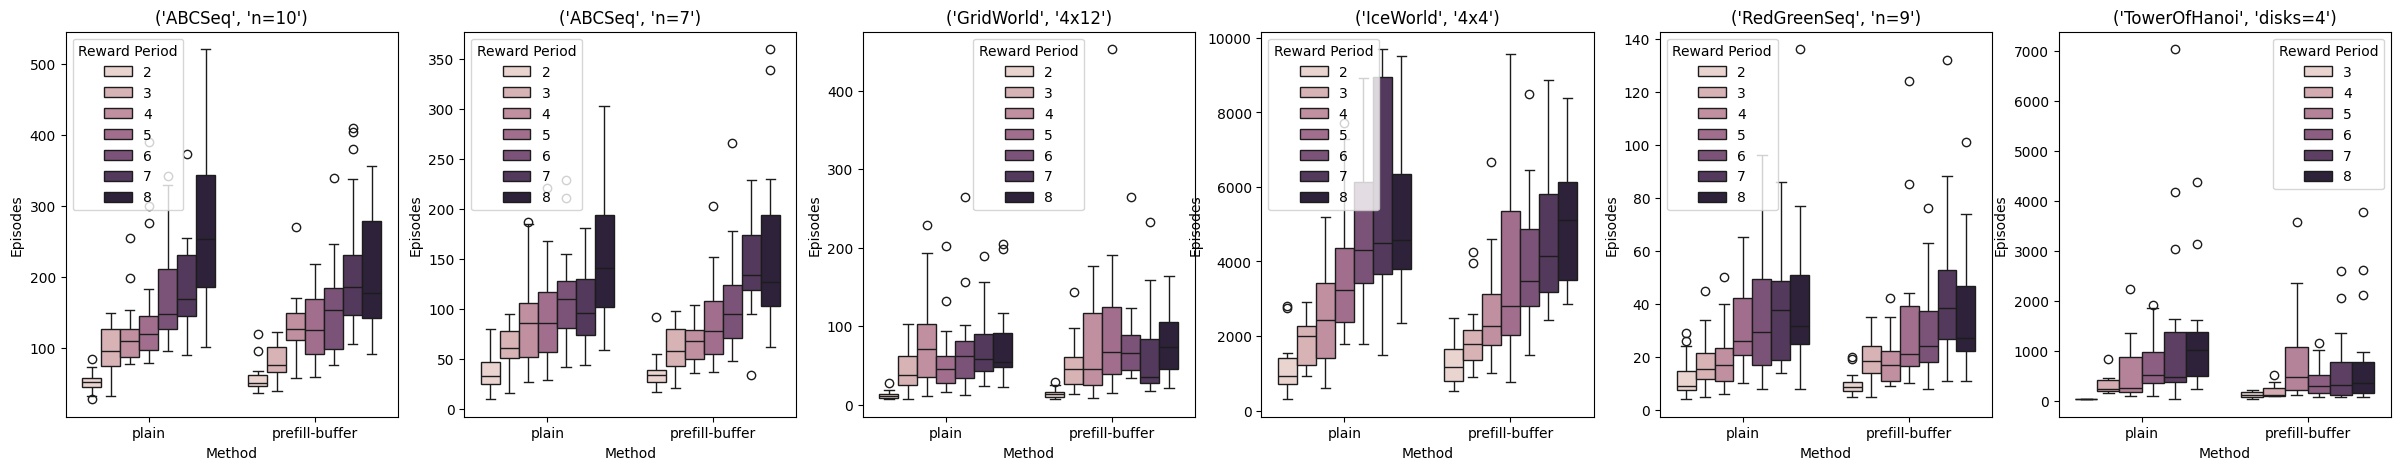

In [27]:
plot_time_till_fullrank(df_results, "episodes")

In [28]:
df_results.iloc[0]

uid                                          b32ca8d7-fa45-42b2-8251-cc5c7c3747c9
env_spec                        {'name': 'GridWorld', 'args': {'grid': 'oooooo...
run_id                                                                          4
reward_period                                                                   3
accuracy                                                                      0.0
max_episodes                                                                10000
log_episode_frequency                                                         100
method                                                             prefill-buffer
least                           [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
ols_em                          [-1.0, -1.0, -1.0, -1.0, -1.0, -0.9999999999, ...
episodes                                                                       22
steps                                                                      119995
full_rank       

## Time to Full Rank - By Steps

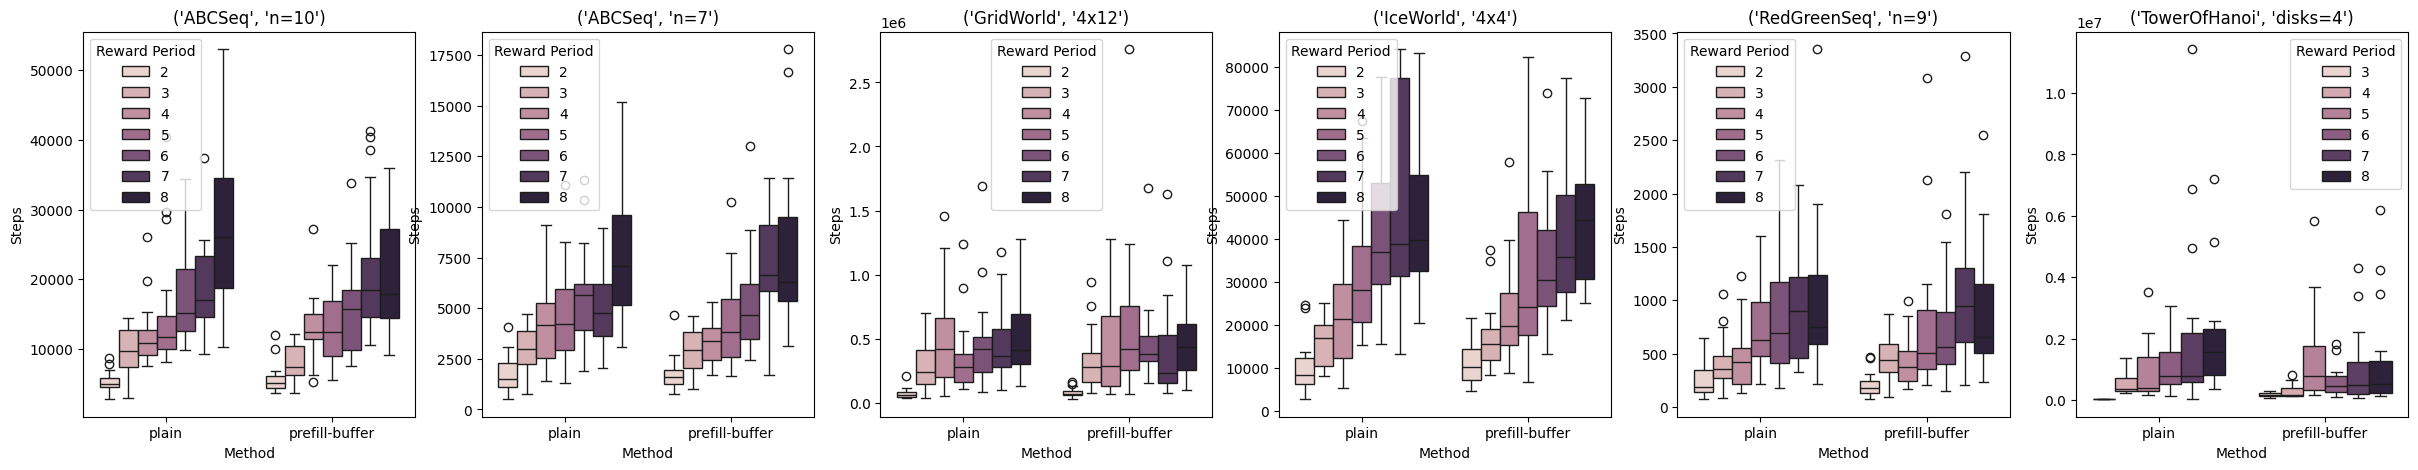

In [29]:
plot_time_till_fullrank(df_results, "steps")

## State Visitation/Coverage

In [30]:
df_results

,uid,env_spec,run_id,reward_period,accuracy,max_episodes,log_episode_frequency,method,least,ols_em,episodes,steps,full_rank,samples,buffer_size,episode_visited_states_count,meta,env_name,env_level,env_label
0,b32ca8d7-fa45-42b2-8251-cc5c7c3747c9,"{'name': 'GridWorld', 'args': {'grid': 'oooooo...",4,3,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -0.9999999999, ...",22,119995,True,1693,155648,"{'34': 2, '38': 12, '36': 4, '37': 2, '30': 1,...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12
1,884ce390-e03a-483a-81b0-93f37669097f,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",16,8,1.000000e-08,10000,100,plain,None,None,10000,329975,False,19339,262144,"{'18': 258, '10': 1051, '23': 88, '12': 929, '...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
2,2f86d7bf-a0e4-4727-98a1-5f6a28428aa2,"{'name': 'IceWorld', 'args': {'map_name': '4x4'}}",13,6,1.000000e-08,10000,100,plain,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -32...","[-1.0000004423, -1.0000022971, -0.999999528400...",4330,37431,True,1471,65536,"{'6': 419, '8': 81, '3': 1729, '4': 1009, '5':...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4
3,ce93319e-9dbc-4f1b-b50f-f3968a2ad151,"{'name': 'ABCSeq', 'args': {'length': 10, 'dis...",16,7,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0000000001, -1.0, -1.0, -1.0, -1.0, -1.0, ...",240,23589,True,2946,112640,{'11': 240},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",ABCSeq,10,n=10
4,dab32a7a-df2e-44c3-a452-c0514eda0c42,"{'name': 'TowerOfHanoi', 'args': {'num_disks':...",6,3,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",203,315773,True,3337,497664,"{'75': 5, '50': 4, '32': 1, '81': 22, '80': 18...","{'max_episodes': 10000, 'est_accuracy': 1e-08,...",TowerOfHanoi,4,disks=4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0b3c4513-336b-4f6d-9d9a-063648b152d8,"{'name': 'RedGreenSeq', 'args': {'cure': ['red...",9,6,1.000000e-08,10000,100,prefill-buffer,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.000000551, -0.999999767, -0.9999999787, -0...",12,317,True,49,27648,{'9': 12},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9
2236,b930dc60-061c-4ba5-b247-fe9560b25705,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",19,5,1.000000e-08,10000,100,plain,None,None,10000,328087,False,11032,262144,"{'18': 265, '13': 829, '8': 928, '21': 163, '9...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8
2237,cbf5f4cd-f84c-4bd0-8827-d010c0ed0dea,"{'name': 'ABCSeq', 'args': {'length': 7, 'dist...",10,2,1.000000e-08,10000,100,plain,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",56,2598,True,233,57344,{'8': 56},"{'max_episodes': 10000, 'est_accuracy': 1e-08,...",ABCSeq,7,n=7
2238,29d4cace-7025-4541-9131-8020de4173d9,"{'name': 'IceWorld', 'args': {'map_name': '8x8'}}",9,4,1.000000e-08,10000,100,plain,None,None,10000,333099,False,5260,262144,"{'12': 893, '17': 357, '18': 269, '14': 652, '...","{'max_episodes': 10000, 'est_accuracy': 1e-08}",IceWorld,JKNDNWGM45FELU53ZLLVJEPY2SFZBCX54PSACOQOFMTDUA...,8x8


In [31]:
def calculate_state_coverage(df_results: pd.DataFrame, env_info, exclude_envs=EXCLUDED_ENVS, output_dir: str = "figures/state_coverage"):
    mask = df_results["env_name"].apply(lambda env: env not in exclude_envs)
    df_raw = copy.deepcopy(
        df_results[mask][["env_name", "env_level", "env_label", "episode_visited_states_count", "episodes"]]
    )

    rows = []
    for row in df_raw.to_dict("records"):
        eid = (row["env_name"],  row["env_level"])
        unique_state_counts_across_episodes_in_run = set([int(unique_state_count) for unique_state_count in row["episode_visited_states_count"].keys()])
        num_states = env_info[eid]["desc"].num_states
        for count in unique_state_counts_across_episodes_in_run:
            rows.append(
                {
                    "eid": eid,
                    "num_states_visited": count,
                    "states_coverage": count / num_states,
                    **copy.deepcopy(row)
                    
                }
            )

    # in how many runs to we get full coverage (not per episode nor across runs)
    df_proc = pd.DataFrame(rows)
    eids = sorted(df_proc["eid"].unique())
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
    fig, axes = plt.subplots(ncols=len(eids), figsize=(5 * len(eids), 5))
    for eid, ax in zip(eids, axes.flatten()):
        df_plot = df_proc[df_proc["eid"] == eid]
        sns.histplot(
            data=df_plot, x="states_coverage",
            binrange=(0.0, 1.0), binwidth=0.1,
            ax=ax
        )
        sample_row = df_plot.iloc[0]
        ax.set_xlabel(",".join([sample_row["env_name"], sample_row["env_label"]]))
        
    fname = "".join(["state_coverage", ".pdf"])
    plt.savefig(os.path.join(output_dir, fname), format="pdf", dpi=300, transparent= True)

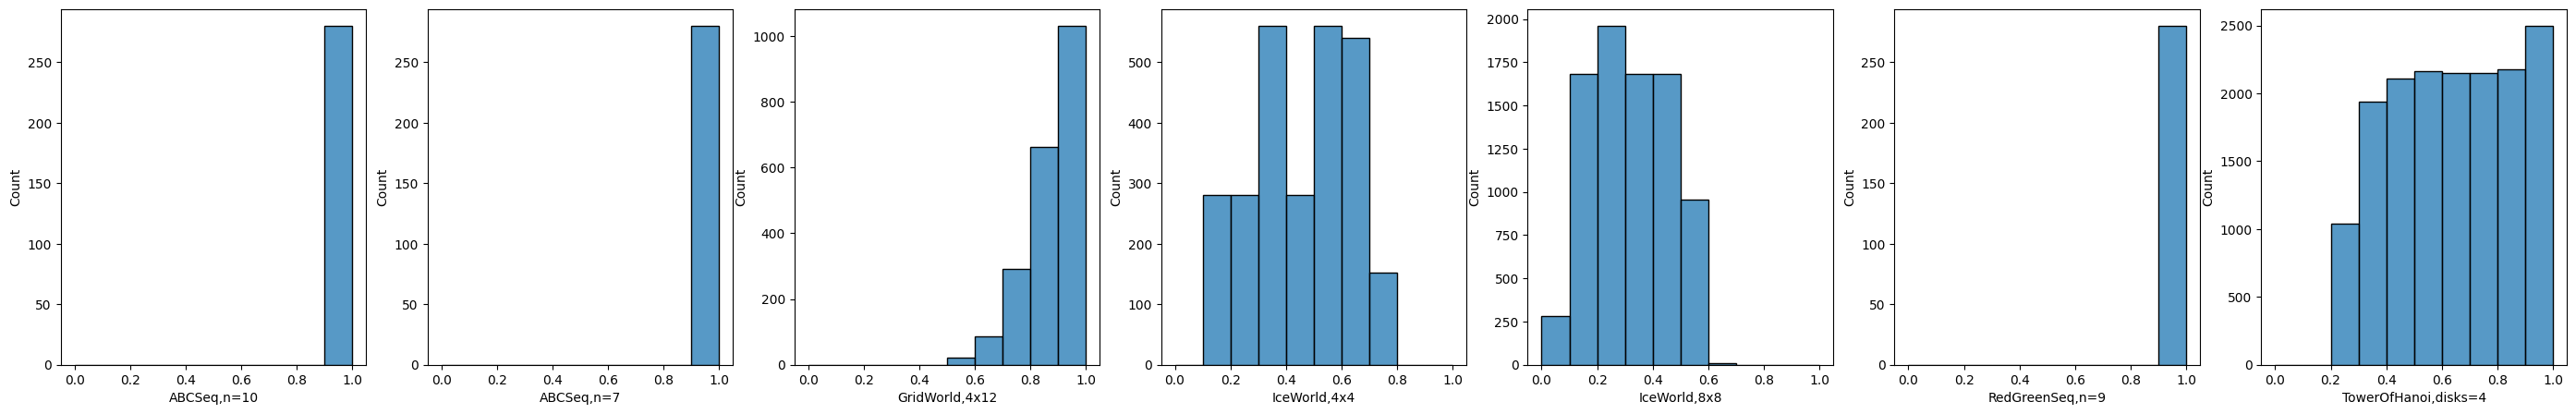

In [32]:
calculate_state_coverage(df_results, env_info)

## Estimation Error

What is the error in recovering the reward function/matrix?

In [33]:
df_results.isnull().sum(axis = 0)

uid                               0
env_spec                          0
run_id                            0
reward_period                     0
accuracy                          0
max_episodes                      0
log_episode_frequency             0
method                            0
least                           434
ols_em                          434
episodes                          0
steps                             0
full_rank                         0
samples                           0
buffer_size                       0
episode_visited_states_count      0
meta                              0
env_name                          0
env_level                         0
env_label                         0
dtype: int64

In [34]:
def estimation_error(df_results: pd.DataFrame, env_info):
    def rmse(vpred, vtrue):
        return estimator_metrics.rmse(v_pred=vpred, v_true=vtrue, axis=0) if np.sum(np.isnan(vpred)) == 0 else None

    def equality(vpred, vtrue):
        return np.allclose(vpred, vtrue, atol=1e-02) if np.sum(np.isnan(vpred)) == 0 else None
    
    df_raw = copy.deepcopy(
        df_results[
            df_results["full_rank"]
        ][["env_name", "env_level", "env_label", "ols_em", "least", "reward_period", "method"]]
    )
    rows = []
    for row in df_raw.to_dict("records"):
        eid = (row["env_name"],  row["env_level"])
        vtrue = np.reshape(env_info[eid]["reward_m"], [-1])
        least = np.array(row["least"], dtype=np.float64)
        ols_em = np.array(row["ols_em"], dtype=np.float64)

        least_rmse = estimator_metrics.rmse(v_pred=least, v_true=vtrue, axis=0) if np.sum(np.isnan(least)) == 0 else None
        ols_em_rmse = estimator_metrics.rmse(v_pred=ols_em, v_true=vtrue, axis=0) if np.sum(np.isnan(ols_em)) == 0 else None
        
        rows.append(
            {
                "eid": (row["env_name"],  row["env_label"]),
                "rmse": {
                    "least": rmse(least, vtrue=vtrue),
                    "ols_em": rmse(ols_em, vtrue=vtrue),
                },
                "equality": {
                    "least": equality(least, vtrue=vtrue),
                    "ols_em": equality(ols_em, vtrue=vtrue),
                },
                **row
            }
        )
    df_proc = pd.DataFrame(rows)
    return df_proc

In [35]:
df_est_error = estimation_error(df_results, env_info)

In [36]:
df_est_error

,eid,rmse,equality,env_name,env_level,env_label,ols_em,least,reward_period,method
0,"(GridWorld, 4x12)","{'least': 7.878910479018395e-17, 'ols_em': 4.0...","{'least': True, 'ols_em': True}",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12,"[-1.0, -1.0, -1.0, -1.0, -1.0, -0.9999999999, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",3,prefill-buffer
1,"(IceWorld, 4x4)","{'least': 2.1772511923649e-16, 'ols_em': 0.000...","{'least': True, 'ols_em': True}",IceWorld,4KE3ASUFQGGUPERSDDRQAZAMA46CI2CMCJHGWJ7MRNI64J...,4x4,"[-1.0000004423, -1.0000022971, -0.999999528400...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -32...",6,plain
2,"(ABCSeq, n=10)","{'least': 1.7219153665103197e-16, 'ols_em': 0....","{'least': True, 'ols_em': True}",ABCSeq,10,n=10,"[-1.0000000001, -1.0, -1.0, -1.0, -1.0, -1.0, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",7,prefill-buffer
3,"(TowerOfHanoi, disks=4)","{'least': 2.4547875008148853e-17, 'ols_em': 2....","{'least': True, 'ols_em': True}",TowerOfHanoi,4,disks=4,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",3,prefill-buffer
4,"(ABCSeq, n=7)","{'least': 1.066451475528809e-16, 'ols_em': 8.6...","{'least': True, 'ols_em': True}",ABCSeq,7,n=7,"[-1.0000000002, -1.0, -1.0, -1.0, -1.0, -1.0, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",3,plain
...,...,...,...,...,...,...,...,...,...,...
1801,"(ABCSeq, n=7)","{'least': 1.9673462592140282e-16, 'ols_em': 0....","{'least': True, 'ols_em': True}",ABCSeq,7,n=7,"[-0.9999999891, -0.9999999987, -1.0000000005, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",5,prefill-buffer
1802,"(FrozenLake-v1, 4x4)","{'least': 8.957020911123518e-18, 'ols_em': None}","{'least': True, 'ols_em': None}",FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,"[None, None, None, None, None, None, None, Non...","[4.6777481319999996e-20, 3.496996825e-19, -2.5...",5,plain
1803,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.227...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.000000551, -0.999999767, -0.9999999787, -0...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",6,prefill-buffer
1804,"(ABCSeq, n=7)","{'least': 5.112313186312647e-17, 'ols_em': 6.4...","{'least': True, 'ols_em': True}",ABCSeq,7,n=7,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",2,plain


### Equality with True Rewards

How many times did each method arrive at a result?

In [37]:
def est_equality(df_est_error: pd.DataFrame):
    df_raw = copy.deepcopy(
        df_est_error[["eid", "equality", "env_name", "env_label", "method"]]
    )
    for est_method in ("least", "ols_em"):
        df_raw[est_method] = df_raw["equality"].apply(lambda eq: eq[est_method])
    del df_raw["equality"]
    return df_raw.groupby(["eid", "env_name", "env_label", "method"]).agg({"least": ["sum", "count"], "ols_em": ["sum", "count"]}).reset_index()

In [38]:
df_est_eq = est_equality(df_est_error)

In [39]:
df_est_eq

eid       env_name env_label          method least  \
                                                                       sum   
0            (ABCSeq, n=10)         ABCSeq      n=10           plain   140   
1            (ABCSeq, n=10)         ABCSeq      n=10  prefill-buffer   140   
2             (ABCSeq, n=7)         ABCSeq       n=7           plain   140   
3             (ABCSeq, n=7)         ABCSeq       n=7  prefill-buffer   140   
4      (FrozenLake-v1, 4x4)  FrozenLake-v1       4x4           plain   135   
5      (FrozenLake-v1, 4x4)  FrozenLake-v1       4x4  prefill-buffer   132   
6         (GridWorld, 4x12)      GridWorld      4x12           plain   139   
7         (GridWorld, 4x12)      GridWorld      4x12  prefill-buffer   139   
8           (IceWorld, 4x4)       IceWorld       4x4           plain   132   
9           (IceWorld, 4x4)       IceWorld       4x4  prefill-buffer   135   
10       (RedGreenSeq, n=9)    RedGreenSeq       n=9           plain   133   
11       (RedGreenSeq, n=9)    RedGreenSeq       n=9  prefill-buffer   134   
12  (TowerOfHanoi, disks=4)   TowerOfHanoi   disks=4           plain    72   
13  (TowerOfHanoi, disks=4)   TowerOfHanoi   disks=4  prefill-buffer    76   

         ols_em        
   count    sum count  
0    140    140   140  
1    140    140   140  
2    140    140   140  
3    140    140   140  
4    136      0     0  
5    133      0     0  
6    140    139   140  
7    140    139   140  
8    132    132   132  
9    135    135   135  
10   140    134   140  
11   140    133   140  
12    74     72    74  
13    76     76    76

### Error plots

In [40]:
def plot_est_error(df_est_error: pd.DataFrame, exclude_envs: Set[str] = EXCLUDED_ENVS, output_dir: str = "figures/est_error"):
    from matplotlib import ticker
    mask = df_est_error["env_name"].apply(lambda env: env not in exclude_envs)
    df_raw = copy.deepcopy(
        df_est_error[mask][["eid", "env_name", "env_level", "env_name", "rmse", "reward_period", "method"]]
    )
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    est_methods = sorted(["least", "ols_em"])
    for row, est_method in enumerate(est_methods):
        print(est_method)
        df_est_method = copy.deepcopy(df_raw)
        df_est_method["rmse"] = df_est_method["rmse"].apply(lambda entry: entry[est_method])
        df_est_method = df_est_method[~np.isnan(df_est_method["rmse"])]
        eids = sorted(df_est_method["eid"].unique())
        fig, axes = plt.subplots(ncols=len(eids), figsize=(5 * len(eids), 5))
        for eid, ax in zip(eids, axes.flatten()):
            df_plot = copy.deepcopy(df_est_method[df_est_method["eid"] == eid])
            df_plot = df_plot.rename(
                {
                    "eid": "Environment",
                    "rmse": "RMSE",
                    "reward_period": "Reward Period",
                    "method": "Method",
                },
                axis=1,
            ).sort_values(["Method", "Reward Period"])
            sns.boxplot(data=df_plot, x="Method", y="RMSE", hue="Reward Period", ax=ax)
            ax.set_title(eid)
            ax.ticklabel_format(axis="y", style='sci', scilimits=(0,0))
        fname = "".join([est_method, ".pdf"])
        fig.savefig(os.path.join(output_dir, fname), format="pdf", dpi=300, transparent=True, bbox_inches="tight",)   

least
ols_em


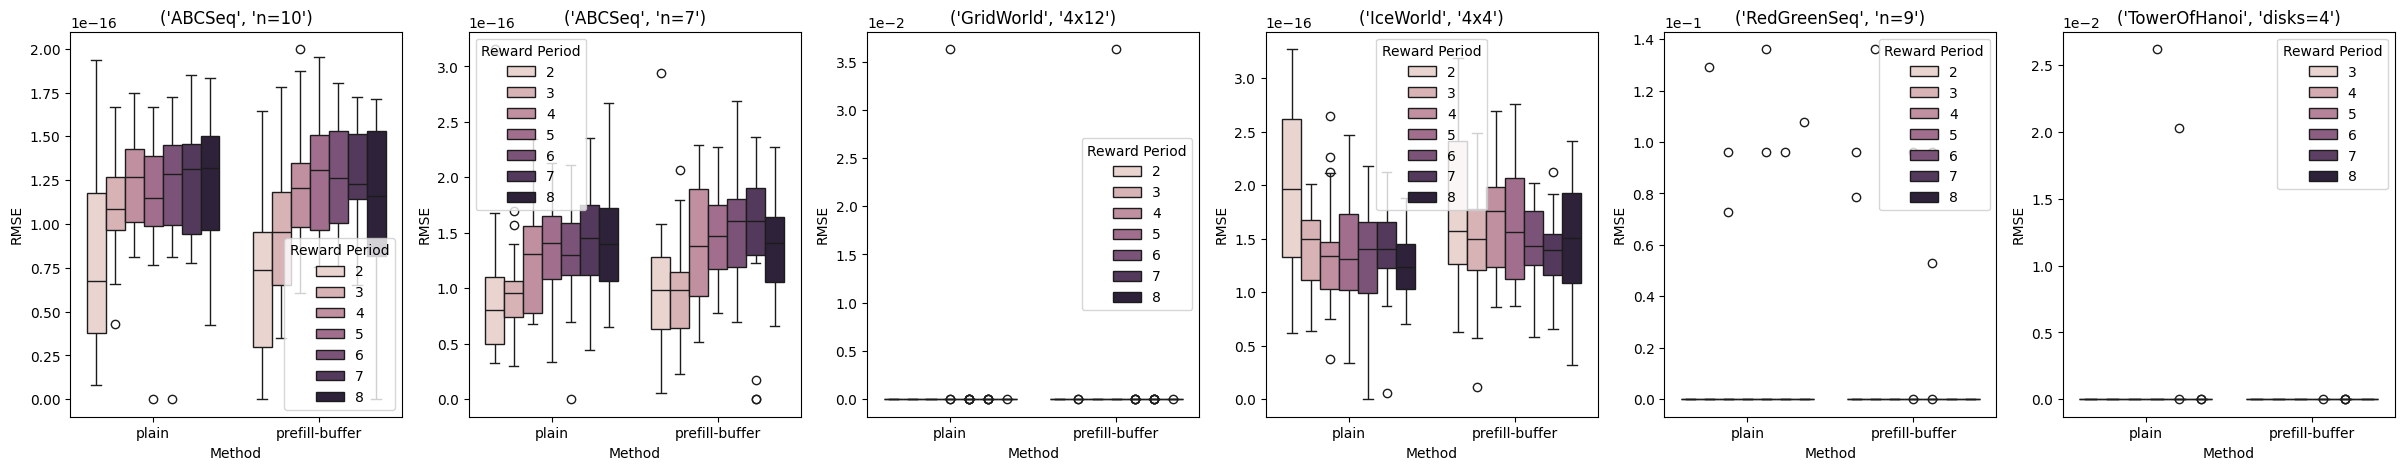

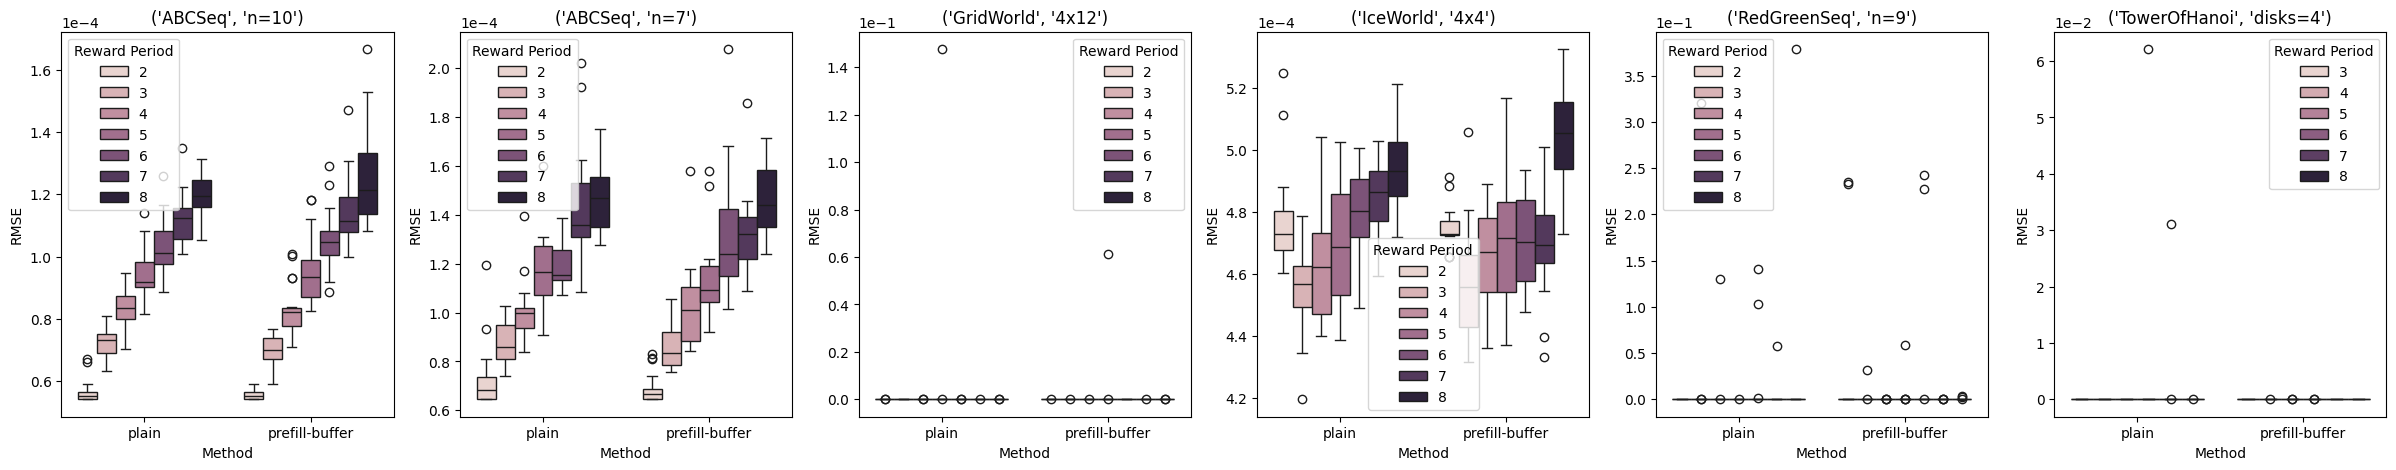

In [41]:
plot_est_error(df_est_error)

## Failed Estimations (i.e Not Equal)

In [42]:
def get_failed_estimations(df, method: str):
    return df[df["equality"].apply(lambda eq: eq[method] is False)]

In [43]:
df_neq = get_failed_estimations(df_est_error, method="least")

In [44]:
df_neq

,eid,rmse,equality,env_name,env_level,env_label,ols_em,least,reward_period,method
302,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.141...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000968, -1.0000000078, -0.999999984600...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",6,plain
357,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.233...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000002, -1.0, -1.0, -1.0, -0.999999999...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",2,prefill-buffer
382,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.057...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999998910000001, -1.0000000358, -1.000000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",7,plain
425,"(RedGreenSeq, n=9)","{'least': 0.07273929675260474, 'ols_em': 0.000...","{'least': False, 'ols_em': True}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000035, -0.9999999997000001, -0.999999...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",4,plain
471,"(RedGreenSeq, n=9)","{'least': 0.12909944487358055, 'ols_em': 0.320...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.8898625844, -1.1746450358, -0.6507099285, ...","[-1.0, -1.2, -0.6000000000000001, -1.0, -1.0, ...",3,plain
553,"(FrozenLake-v1, 4x4)","{'least': 0.05590169943749474, 'ols_em': None}","{'least': False, 'ols_em': None}",FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,"[None, None, None, None, None, None, None, Non...","[6.458119907e-20, -1.870901829e-19, -5.5269279...",3,plain
585,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.130...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000329, -1.0000000067, -0.999999988900...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",4,plain
595,"(RedGreenSeq, n=9)","{'least': 0.1077513639754486, 'ols_em': 0.3784...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999977517, -0.9999960875, -0.999999928500...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",8,plain
942,"(FrozenLake-v1, 4x4)","{'least': 0.05590169943749474, 'ols_em': None}","{'least': False, 'ols_em': None}",FrozenLake-v1,U75ZLQLLXYRFQE5KOJJGNVQZGQ65U5RVVN3ZV5F4UNYQVK...,4x4,"[None, None, None, None, None, None, None, Non...","[1.128208978e-20, 1.2265401380000002e-18, 5.32...",3,prefill-buffer
990,"(RedGreenSeq, n=9)","{'least': 0.05300789877351912, 'ols_em': 0.242...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999995726, -1.0000007077, -0.9999992935, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",6,prefill-buffer


### GridWorld

In [45]:
df_neq[df_neq["env_name"] == "GridWorld"]

,eid,rmse,equality,env_name,env_level,env_label,ols_em,least,reward_period,method
1352,"(GridWorld, 4x12)","{'least': 0.03627381250550058, 'ols_em': 0.061...","{'least': False, 'ols_em': False}",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",5,prefill-buffer
1661,"(GridWorld, 4x12)","{'least': 0.03627381250550058, 'ols_em': 0.147...","{'least': False, 'ols_em': False}",GridWorld,P3VJZBIJ7PNUOFG2SCF532NH5AQ6NOBZEZ6UZNZ7D3AU3G...,4x12,"[-1.0, -1.0000000004, -1.0, -1.0000000012, -0....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",5,plain


In [46]:
extract_env_info(spec={"name": "GridWorld", "args": {"grid": "oooooooooooo\noooooooooooo\noooooooooooo\nsxxxxxxxxxxg"}})

{'reward_m': array([[  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1., -100.],


**LEAST**

In [47]:
np.reshape(df_neq[df_neq["env_name"] == "GridWorld"]["least"].iloc[0], newshape=(-1, 4))

array([[  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. , 

In [48]:
np.reshape(df_neq[df_neq["env_name"] == "GridWorld"]["least"].iloc[1], newshape=(-1, 4))

array([[  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. ,   -1. ,   -1. ,   -1. ],
       [  -1. , 

In the run above, the estimation for rewards for the terminal states and one other non-terminal state (state above the terminal one) in GridWorld are incorrect.
Note that the error still occurs even when the buffer is pre-filled for terminal states - so data alone can be insufficient.
This kind of error can/needs to be avoided; perhaps using constrained optimisation, since we know for the fact the rewards for any action in a terminal state is zero.


**OLS**

In [49]:
np.reshape(df_neq[df_neq["env_name"] == "GridWorld"]["ols_em"].iloc[0], newshape=(-1, 4))

array([[  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -0.99999999],
       [  -1.        ,   -0.99999998,   -1.        ,   -0.99999998],
       [  -1.00000002,   -1.00000001,   -1.00000001,   -1.00000008],
       [  -0.99999999,   -1.00000002,   -1.        ,   -1.        ],
       [  -0.99999999,   -1.0000001 ,   -1.00000001,   -0.99999998],
       [  -0.99999993,   -0.99999997,   -1.00000002,   -0.9999999 ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.      

In [50]:
np.reshape(df_neq[df_neq["env_name"] == "GridWorld"]["ols_em"].iloc[0], newshape=(-1, 4))

array([[  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -0.99999999],
       [  -1.        ,   -0.99999998,   -1.        ,   -0.99999998],
       [  -1.00000002,   -1.00000001,   -1.00000001,   -1.00000008],
       [  -0.99999999,   -1.00000002,   -1.        ,   -1.        ],
       [  -0.99999999,   -1.0000001 ,   -1.00000001,   -0.99999998],
       [  -0.99999993,   -0.99999997,   -1.00000002,   -0.9999999 ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.        ,   -1.        ,   -1.        ],
       [  -1.        ,   -1.      

The same happens with the OLS estimatior. Both estimators use the same data/matrix.

### RedGreen

In [51]:
df_neq[df_neq["env_name"] == "RedGreenSeq"]

,eid,rmse,equality,env_name,env_level,env_label,ols_em,least,reward_period,method
302,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.141...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000968, -1.0000000078, -0.999999984600...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",6,plain
357,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.233...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000002, -1.0, -1.0, -1.0, -0.999999999...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",2,prefill-buffer
382,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.057...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999998910000001, -1.0000000358, -1.000000...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",7,plain
425,"(RedGreenSeq, n=9)","{'least': 0.07273929675260474, 'ols_em': 0.000...","{'least': False, 'ols_em': True}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000035, -0.9999999997000001, -0.999999...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",4,plain
471,"(RedGreenSeq, n=9)","{'least': 0.12909944487358055, 'ols_em': 0.320...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.8898625844, -1.1746450358, -0.6507099285, ...","[-1.0, -1.2, -0.6000000000000001, -1.0, -1.0, ...",3,plain
585,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.130...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0000000329, -1.0000000067, -0.999999988900...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",4,plain
595,"(RedGreenSeq, n=9)","{'least': 0.1077513639754486, 'ols_em': 0.3784...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999977517, -0.9999960875, -0.999999928500...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",8,plain
990,"(RedGreenSeq, n=9)","{'least': 0.05300789877351912, 'ols_em': 0.242...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999995726, -1.0000007077, -0.9999992935, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",6,prefill-buffer
1041,"(RedGreenSeq, n=9)","{'least': 0.07856742014755211, 'ols_em': 0.234...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",2,prefill-buffer
1117,"(RedGreenSeq, n=9)","{'least': 0.09622504486493763, 'ols_em': 0.058...","{'least': False, 'ols_em': False}",RedGreenSeq,NNLHYJFTC5ENMMDZWRNQ37B6VVDXQ7WHB5EJOPXYZFLMJE...,n=9,"[-0.9999996888, -1.0000000235, -1.0000001402, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",5,prefill-buffer


In [52]:
extract_env_info(spec={"name": "RedGreenSeq", "args": {"cure": ["red", "green", "wait", "green", "red", "red", "green", "wait"]}})

{'reward_m': array([[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [ 0.,  0.,  0.]]),
 'desc': EnvDesc(num_states=9, num_actions=3),
 'terminal_states': {8}}

In [53]:
np.reshape(df_neq[df_neq["env_name"] == "RedGreenSeq"]["least"].iloc[0], newshape=(-1, 3))

array([[-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -0.75],
       [-0.25, -0.25, -0.25]])

In [54]:
np.reshape(df_neq[df_neq["env_name"] == "RedGreenSeq"]["least"].iloc[0], newshape=(-1, 3))

array([[-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -1.  ],
       [-1.  , -1.  , -0.75],
       [-0.25, -0.25, -0.25]])